# H2o Playground

Explorar funcionalidades del _framework_ H2o.

In [1]:
# Cargar librerias
import h2o
from h2o.automl import H2OAutoML
import os
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv

Cargamos credenciales desde el archivo `.env`.

In [2]:
%%capture
load_dotenv()
schema = "h2o"
conn_url = os.getenv('MARIADB_URL') + schema
username = os.getenv('MARIADB_USER')
password = os.getenv('MARIADB_PASS')
table = 'cars_20mpg'

Establecer conexión:

In [3]:
%%capture
h2o.init(extra_classpath=["drivers/mariadb-java-client-3.0.5.jar"])

Traerse una tabla desde la base de datos:

In [4]:
mpg = h2o.import_sql_table(conn_url, table, username, password)

Import SQL Table progress: |█████████████████████████████████████████████████████| (done) 100%


La tabla se guarda en un objeto `h2o.frame.H2OFrame`.

In [5]:
type(mpg)

h2o.frame.H2OFrame

In [6]:
mpg

name,economy,cylinders,displacement,power,weight,acceleration,year,economy_20mpg
AMC Ambassador Brougham,13,8,360,175,3821,11,73,0
AMC Ambassador DPL,15,8,390,190,3850,8.5,70,0
AMC Ambassador SST,17,8,304,150,3672,11.5,72,0
AMC Concord DL 6,20.2,6,232,90,3265,18.2,79,1
AMC Concord DL,18.1,6,258,120,3410,15.1,78,0
AMC Concord DL,23,4,151,nan,3035,20.5,82,1
AMC Concord,19.4,6,232,90,3210,17.2,78,0
AMC Concord,24.3,4,151,90,3003,20.1,80,1
AMC Gremlin,18,6,232,100,2789,15,73,0
AMC Gremlin,19,6,232,100,2634,13,71,0


Es posible transformar el objeto `H20Frame` a `pd.DataFrame` con el método `.as_data_frame()`.

In [125]:
mpg_df = mpg.as_data_frame()
mpg_df.head(n=3)

,name,economy,cylinders,displacement,power,weight,acceleration,year,economy_20mpg
0,AMC Ambassador Brougham,13.0,8,360.0,175.0,3821,11.0,73,0.0
1,AMC Ambassador DPL,15.0,8,390.0,190.0,3850,8.5,70,0.0
2,AMC Ambassador SST,17.0,8,304.0,150.0,3672,11.5,72,0.0


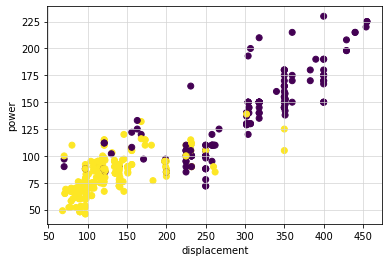

In [126]:
plt.scatter(mpg_df.displacement, mpg_df.power, c=mpg_df.economy_20mpg);
plt.xlabel('displacement');
plt.ylabel('power');
plt.grid(linewidth=0.7, color='lightgrey');

In [127]:
mpg_df\
    .loc[mpg_df.displacement > 300, :]\
    .groupby('economy_20mpg')\
    .count()['name']\
    .reset_index()

,economy_20mpg,name
0,0.0,95
1,1.0,3


## H2o workflow

Documentación: https://h2o-release.s3.amazonaws.com/h2o/rel-zumbo/2/docs-website/h2o-docs/starting-h2o.html


Explorar la estructura de un `H20Frame`:

In [128]:
# dimensiones de la tabla
mpg.dim

[406, 9]

In [129]:
mpg_df.shape

(406, 9)

In [130]:
mpg\
    .group_by('cylinders')\
    .mean('displacement')\
    .get_frame()

cylinders,mean_displacement
3,72.5
4,109.901
5,145
6,218.143
8,345.204


Verifiquemos el monto anterior con pandas:

In [131]:
mpg_df[['cylinders', 'displacement']]\
    .groupby('cylinders')\
    .mean()

,displacement
cylinders,
3,72.500000
4,109.900966
5,145.000000
6,218.142857
8,345.203704


## AutoML: Automatic Machine Learning

Una de las funcionalidades de `H2o` es el modulo AutoML que permite correr diferentes modelos de una misma familia con distinta configuración o de diferentes familias.


In [132]:
 predictors = ["displacement", "power", "weight", "acceleration", "year"]
 response = "economy_20mpg"

Traemos los datos directamente desde la tabla `H2o.mpg_cars20`.

In [133]:
select_query = "SELECT * from cars_20mpg"
mariaDBQuery = h2o.import_sql_select(conn_url, select_query, username, password)
print(mariaDBQuery)

Import SQL Table progress: |█████████████████████████████████████████████████████| (done) 100%


name,economy,cylinders,displacement,power,weight,acceleration,year,economy_20mpg
AMC Ambassador Brougham,13,8,360,175,3821,11,73,0
AMC Ambassador DPL,15,8,390,190,3850,8.5,70,0
AMC Ambassador SST,17,8,304,150,3672,11.5,72,0
AMC Concord DL 6,20.2,6,232,90,3265,18.2,79,1
AMC Concord DL,18.1,6,258,120,3410,15.1,78,0
AMC Concord DL,23,4,151,nan,3035,20.5,82,1
AMC Concord,19.4,6,232,90,3210,17.2,78,0
AMC Concord,24.3,4,151,90,3003,20.1,80,1
AMC Gremlin,18,6,232,100,2789,15,73,0
AMC Gremlin,19,6,232,100,2634,13,71,0


Transformamos la variable dependiente (i.e. response) en una categorica.

In [134]:
mariaDBQuery['economy_20mpg'] = mariaDBQuery['economy_20mpg'].asfactor()

Utilizamos el método `.split_frame` para dividir en conjunto de entrenamiento y validación.

In [135]:
train, valid = mariaDBQuery.split_frame(ratios=[.8], seed=42)

Analizamos las dimensiones de caja conjunto de datos.

In [136]:
train.dim, valid.dim

([321, 9], [85, 9])

Ahora le pediremos a `H20` que corra 15 modelos y entregue un reporte con el _ranking_ de los resultados reportados por los modelos una vez ajustados.

In [137]:
aml = H2OAutoML(max_models=15, seed=42)
aml.train(x=predictors, y=response, training_frame=train)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |
02:34:09.707: XGBoost_1_AutoML_3_20220614_23409 [XGBoost def_2] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for XGBoost model: XGBoost_1_AutoML_3_20220614_23409_cv_1.  Details: ERRR on field: _response_column: Response contains missing values (NAs) - not supported by XGBoost.



02:34:10.408: XGBoost_2_AutoML_3_20220614_23409 [XGBoost def_1] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for XGBoost model: XGBoost_2_AutoML_3_20220614_23409_cv_1.  Details: ERRR on field: _response_column: Response contains missing values (NAs) - not supported by XGBoost.


████
02:34:11.740: XGBoost_3_AutoML_3_20220614_23409 [XGBoost def_3] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for XGBoost model: XGBoost_3_AutoML_3_20220614_23409_cv_1.  Details: ERRR on field: _response_column: Response contains missing values (NAs) - not supported by XGBoost.


████████████

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_3_20220614_23409,0.979654,0.176432,0.986297,0.0764057,0.232072,0.0538576
GBM_3_AutoML_3_20220614_23409,0.979356,0.183466,0.986354,0.0793002,0.238072,0.0566782
GBM_grid_1_AutoML_3_20220614_23409_model_2,0.979185,0.185499,0.986247,0.077853,0.240474,0.0578276
GBM_4_AutoML_3_20220614_23409,0.979058,0.183975,0.986138,0.0810241,0.237652,0.0564785
GBM_2_AutoML_3_20220614_23409,0.977908,0.187275,0.984935,0.0728941,0.236869,0.0561068
GBM_grid_1_AutoML_3_20220614_23409_model_1,0.977227,0.202822,0.984735,0.0821947,0.243875,0.0594753
DeepLearning_grid_3_AutoML_3_20220614_23409_model_1,0.977057,0.205477,0.985194,0.0871536,0.249107,0.0620542
DeepLearning_grid_1_AutoML_3_20220614_23409_model_1,0.976163,0.204299,0.984543,0.087707,0.253919,0.0644748
StackedEnsemble_AllModels_1_AutoML_3_20220614_23409,0.975567,0.191446,0.984326,0.0886009,0.248136,0.0615714
StackedEnsemble_BestOfFamily_1_AutoML_3_20220614_23409,0.975482,0.190986,0.983334,0.0850892,0.244192,0.0596295


Es posible pedir un reporta más detallado:

In [138]:
aml.get_leaderboard(extra_columns='ALL')

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GLM_1_AutoML_3_20220614_23409,0.979654,0.176432,0.986297,0.0764057,0.232072,0.0538576,30,0.012491,GLM
GBM_3_AutoML_3_20220614_23409,0.979356,0.183466,0.986354,0.0793002,0.238072,0.0566782,77,0.018185,GBM
GBM_grid_1_AutoML_3_20220614_23409_model_2,0.979185,0.185499,0.986247,0.077853,0.240474,0.0578276,81,0.019523,GBM
GBM_4_AutoML_3_20220614_23409,0.979058,0.183975,0.986138,0.0810241,0.237652,0.0564785,101,0.020173,GBM
GBM_2_AutoML_3_20220614_23409,0.977908,0.187275,0.984935,0.0728941,0.236869,0.0561068,85,0.046593,GBM
GBM_grid_1_AutoML_3_20220614_23409_model_1,0.977227,0.202822,0.984735,0.0821947,0.243875,0.0594753,59,0.033784,GBM
DeepLearning_grid_3_AutoML_3_20220614_23409_model_1,0.977057,0.205477,0.985194,0.0871536,0.249107,0.0620542,5046,0.02522,DeepLearning
DeepLearning_grid_1_AutoML_3_20220614_23409_model_1,0.976163,0.204299,0.984543,0.087707,0.253919,0.0644748,5430,0.019073,DeepLearning
StackedEnsemble_AllModels_1_AutoML_3_20220614_23409,0.975567,0.191446,0.984326,0.0886009,0.248136,0.0615714,1030,0.063799,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_3_20220614_23409,0.975482,0.190986,0.983334,0.0850892,0.244192,0.0596295,1054,0.033428,StackedEnsemble


¿Cómo podemos extraer información más detallada de uno de los modelos anteriores?

Utilizar `h2o.get_model('model_id')`, donde `model_id` están especificados en el reporte de arriba.

Extraigamos una de las redes neuronales.

In [139]:
h2o.get_model('DeepLearning_grid_1_AutoML_2_20220614_20958_model_1')

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_2_20220614_20958_model_1


Status of Neuron Layers: predicting economy_20mpg, 2-class classification, bernoulli distribution, CrossEntropy loss, 162 weights/biases, 5.4 KB, 3,212,220 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,5,Input,15.0,,,,,,,,,
1,,2,20,RectifierDropout,0.0,0.0,0.0,0.000719,0.000406,0.0,0.051329,1.029756,1.088549,0.493657
2,,3,2,Softmax,,0.0,0.0,0.000918,0.000377,0.0,-0.120623,2.195915,-0.016103,0.451796




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.024382704183607783
RMSE: 0.15614962114461817
LogLoss: 0.07510856755316599
Mean Per-Class Error: 0.028178606393393778
AUC: 0.997786574724386
AUCPR: 0.9986173959821428
Gini: 0.9955731494487721

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6640995589441719: 


,,0,1,Error,Rate
0,0,118.0,5.0,0.0407,(5.0/123.0)
1,1,3.0,188.0,0.0157,(3.0/191.0)
2,Total,121.0,193.0,0.0255,(8.0/314.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,6.640996e-01,0.979167,182.0
1,max f2,3.747227e-01,0.986570,193.0
2,max f0point5,8.872816e-01,0.989071,170.0
3,max accuracy,8.307090e-01,0.974522,174.0
4,max precision,9.999999e-01,1.000000,0.0
5,max recall,3.747227e-01,1.000000,193.0
6,max specificity,9.999999e-01,1.000000,0.0
7,max absolute_mcc,8.307090e-01,0.947747,174.0
8,max min_per_class_accuracy,7.640630e-01,0.973822,178.0
9,max mean_per_class_accuracy,8.307090e-01,0.977610,174.0



Gains/Lift Table: Avg response rate: 60.83 %, avg score: 63.22 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.012739,9.999996e-01,1.643979,1.643979,1.000000,9.999997e-01,1.000000,1.000000,0.020942,0.020942,64.397906,64.397906,0.020942
1,2,0.022293,9.999989e-01,1.643979,1.643979,1.000000,9.999991e-01,1.000000,0.999999,0.015707,0.036649,64.397906,64.397906,0.036649
2,3,0.031847,9.999987e-01,1.643979,1.643979,1.000000,9.999987e-01,1.000000,0.999999,0.015707,0.052356,64.397906,64.397906,0.052356
3,4,0.041401,9.999985e-01,1.643979,1.643979,1.000000,9.999987e-01,1.000000,0.999999,0.015707,0.068063,64.397906,64.397906,0.068063
4,5,0.054140,9.999983e-01,1.643979,1.643979,1.000000,9.999984e-01,1.000000,0.999999,0.020942,0.089005,64.397906,64.397906,0.089005
5,6,0.105096,9.999950e-01,1.643979,1.643979,1.000000,9.999969e-01,1.000000,0.999998,0.083770,0.172775,64.397906,64.397906,0.172775
6,7,0.152866,9.999881e-01,1.643979,1.643979,1.000000,9.999922e-01,1.000000,0.999996,0.078534,0.251309,64.397906,64.397906,0.251309
7,8,0.200637,9.999701e-01,1.643979,1.643979,1.000000,9.999790e-01,1.000000,0.999992,0.078534,0.329843,64.397906,64.397906,0.329843
8,9,0.302548,9.998672e-01,1.643979,1.643979,1.000000,9.999325e-01,1.000000,0.999972,0.167539,0.497382,64.397906,64.397906,0.497382
9,10,0.404459,9.992820e-01,1.643979,1.643979,1.000000,9.996377e-01,1.000000,0.999888,0.167539,0.664921,64.397906,64.397906,0.664921




ModelMetricsBinomial: deeplearning
** Reported on cross-validation data. **

MSE: 0.059245209692248245
RMSE: 0.2434033888265491
LogLoss: 0.19529719455096248
Mean Per-Class Error: 0.08102413484867832
AUC: 0.9775252202783807
AUCPR: 0.9849677351870931
Gini: 0.9550504405567615

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20346925764550555: 


,,0,1,Error,Rate
0,0,105.0,18.0,0.1463,(18.0/123.0)
1,1,3.0,188.0,0.0157,(3.0/191.0)
2,Total,108.0,206.0,0.0669,(21.0/314.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,2.034693e-01,0.947103,194.0
1,max f2,1.836611e-01,0.971223,197.0
2,max f0point5,5.945430e-01,0.942492,175.0
3,max accuracy,2.034693e-01,0.933121,194.0
4,max precision,1.000000e+00,1.000000,0.0
5,max recall,1.277875e-02,1.000000,229.0
6,max specificity,1.000000e+00,1.000000,0.0
7,max absolute_mcc,2.034693e-01,0.861079,194.0
8,max min_per_class_accuracy,5.987975e-01,0.918699,174.0
9,max mean_per_class_accuracy,5.945430e-01,0.922700,175.0



Gains/Lift Table: Avg response rate: 60.83 %, avg score: 60.02 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.019108,1.000000,1.643979,1.643979,1.000000,1.000000,1.000000,1.000000,0.031414,0.031414,64.397906,64.397906,0.031414
1,2,0.022293,1.000000,1.643979,1.643979,1.000000,1.000000,1.000000,1.000000,0.005236,0.036649,64.397906,64.397906,0.036649
2,3,0.031847,1.000000,1.643979,1.643979,1.000000,1.000000,1.000000,1.000000,0.015707,0.052356,64.397906,64.397906,0.052356
3,4,0.041401,1.000000,1.643979,1.643979,1.000000,1.000000,1.000000,1.000000,0.015707,0.068063,64.397906,64.397906,0.068063
4,5,0.054140,0.999999,1.643979,1.643979,1.000000,0.999999,1.000000,1.000000,0.020942,0.089005,64.397906,64.397906,0.089005
5,6,0.105096,0.999844,1.643979,1.643979,1.000000,0.999958,1.000000,0.999980,0.083770,0.172775,64.397906,64.397906,0.172775
6,7,0.152866,0.999522,1.643979,1.643979,1.000000,0.999683,1.000000,0.999887,0.078534,0.251309,64.397906,64.397906,0.251309
7,8,0.203822,0.997997,1.643979,1.643979,1.000000,0.998714,1.000000,0.999594,0.083770,0.335079,64.397906,64.397906,0.335079
8,9,0.305732,0.994075,1.643979,1.643979,1.000000,0.996337,1.000000,0.998508,0.167539,0.502618,64.397906,64.397906,0.502618
9,10,0.404459,0.977055,1.590947,1.631034,0.967742,0.986361,0.992126,0.995543,0.157068,0.659686,59.094748,63.103434,0.651556




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.946025,0.030953,0.920635,1.000000,0.935484,0.937500,0.936508
1,auc,0.977502,0.016288,0.955128,1.000000,0.983351,0.973422,0.975610
2,err,0.053975,0.030953,0.079365,0.000000,0.064516,0.062500,0.063492
3,err_count,3.400000,1.949359,5.000000,0.000000,4.000000,4.000000,4.000000
4,f0point5,0.942339,0.032871,0.917874,1.000000,0.935484,0.930736,0.927602
5,f1,0.956560,0.025866,0.938272,1.000000,0.935484,0.955556,0.953488
6,f2,0.971535,0.024716,0.959596,1.000000,0.935484,0.981735,0.980861
7,lift_top_group,1.663204,0.201539,1.615385,1.675676,2.000000,1.488372,1.536585
8,logloss,0.194945,0.086757,0.283874,0.051422,0.232902,0.200026,0.206500
9,max_per_class_error,0.120695,0.084324,0.166667,0.000000,0.064516,0.190476,0.181818



Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2022-06-14 02:10:23,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-06-14 02:10:23,17.627 sec,209333 obs/sec,9.781931,1,3140.0,0.243848,0.191655,0.750449,0.977695,0.985155,1.643979,0.070064
2,,2022-06-14 02:10:28,22.633 sec,568631 obs/sec,8881.993769,908,2851120.0,0.161416,0.081851,0.890651,0.997787,0.998627,1.643979,0.019108
3,,2022-06-14 02:10:28,23.269 sec,569441 obs/sec,10006.915888,1023,3212220.0,0.156150,0.075109,0.897670,0.997787,0.998617,1.643979,0.025478



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,power,1.000000,1.000000,0.322133
1,displacement,0.623330,0.623330,0.200795
2,weight,0.616602,0.616602,0.198628
3,year,0.477967,0.477967,0.153969
4,acceleration,0.386411,0.386411,0.124476


Se observa que el método tira una verborrea de información sobre el modelo ajustado.